In [1]:
import torch

torch.cuda.is_available()


KeyboardInterrupt



In [2]:
torch.cuda.device_count()

1

In [34]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import normalize

import mygene

import anndata
import networkx as nx
import matplotlib.pyplot as plt

from itertools import count
import itertools
from scipy.spatial import distance_matrix

import seaborn as sns
import math
from slingshot import Slingshot

from itertools import combinations
import bottleneck as bn
from scipy import interpolate
from collections import defaultdict
#import statsmodels.api as sm
import statsmodels as sm

import scipy.stats
from itertools import combinations_with_replacement


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
#sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1+computecanada anndata==0.8.0+computecanada umap==0.5.1+computecanada numpy==1.21.4 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.9 louvain==0.7.0+computecanada pynndescent==0.5.2+computecanada


In [35]:
section_id = '151676'

input_dir = './gvae_model/data'
#input_dir = './human_cortex_data/151676'
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

reading gvae_model/data/151676_filtered_feature_bc_matrix.h5
 (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
np.any((adata.X.toarray() < 0))

False

filtered out 1 cells that have less than 200 counts
filtered out 14864 genes that are detected in less than 3 cells


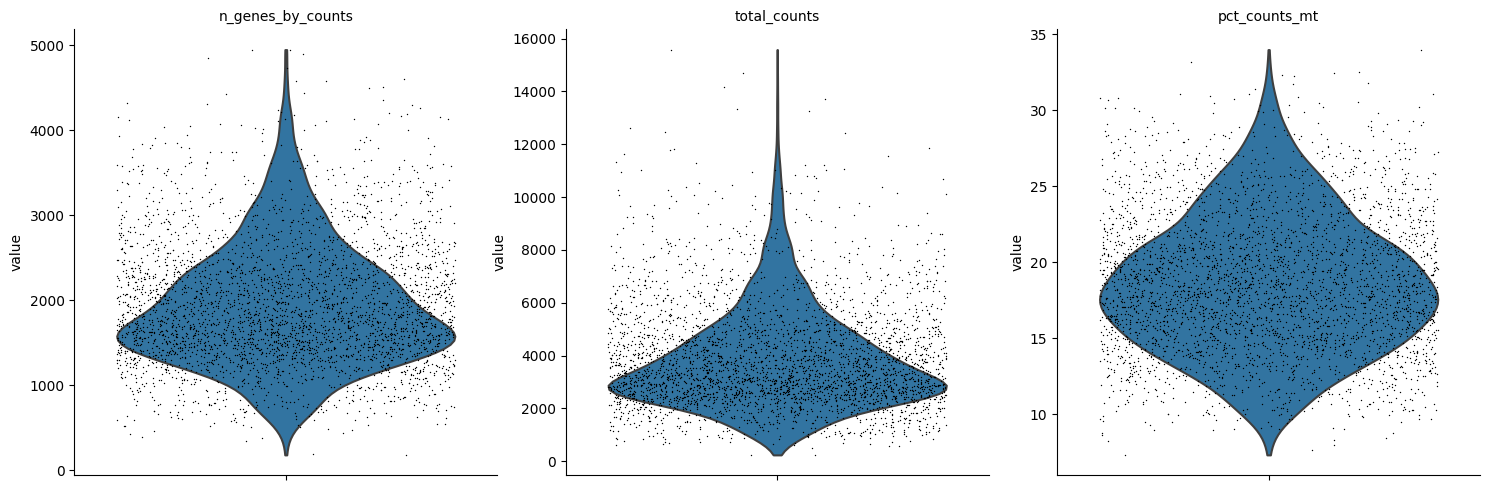

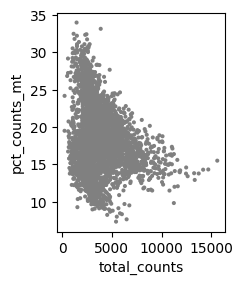

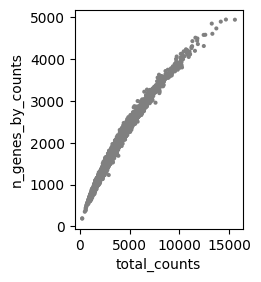

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


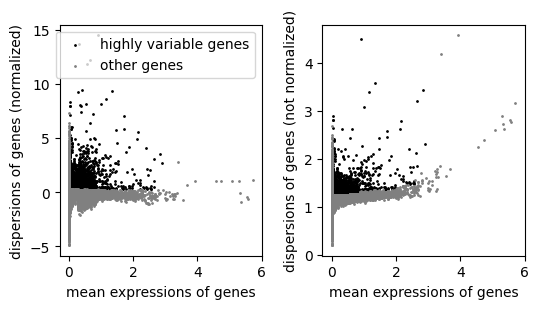

/tmp/ipykernel_197082/1328128258.py:39: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']


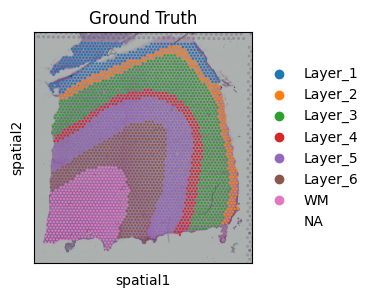

In [36]:
# Filtering
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# Remove cells that have too many mitochondrial genes expressed or too many total counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
# actually do the filtering
#adata = adata[adata.obs.n_genes_by_counts < 4000, :]
#adata = adata[adata.obs.pct_counts_mt < 30, :]

# Normalize 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) #try without

# Filter highly variable genes
#sc.pp.highly_variable_genes(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# regress out
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# scale to unit variance
#sc.pp.scale(adata, max_value=10)


# read the annotation
Ann_df = pd.read_csv(os.path.join(input_dir, 'spatial', section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

In [36]:
adata


AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'Ground Truth_colors'
    obsm: 'spatial'

33538


(array([3.3061e+04, 2.8600e+02, 8.3000e+01, 4.6000e+01, 2.5000e+01,
        1.4000e+01, 4.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.00

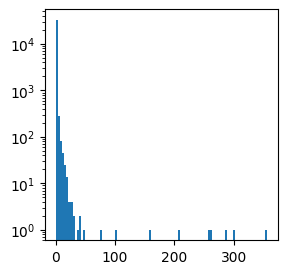

In [6]:
print(len(adata.X[0].toarray()[0]))
plt.hist(adata.X[346].toarray()[0], bins=100, log=True)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


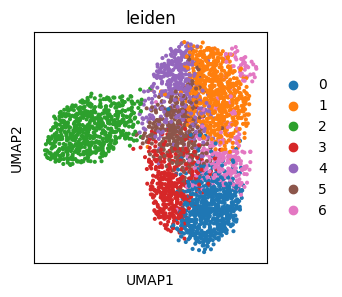

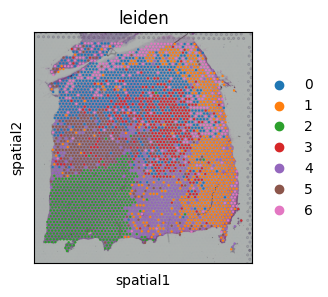

In [37]:
#plt.rcParams["figure.figsize"] = (10,5)
# neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
#sc.pp.neighbors(adata, n_pcs=30)
sc.tl.leiden(adata)
# embedding using UMAP
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
# cluster
sc.pl.umap(adata, color=['leiden'])
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["leiden"])

In [73]:
array = np.ones((4,5))
print(array)
aff = normalize(array, axis=1, norm="l1")
print(aff)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]


In [38]:
# add gene expression
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors

def PCA(adata):
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    # total-count normalize 
    #sc.pp.normalize_total(adata, target_sum=1e4)
    # logarithmize
    #sc.pp.log1p(adata)
    # identify highly variable genes
    #sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=10, min_disp=0.5)
    #adata.raw = adata
    # filtering
    #adata = adata[:, adata.var.highly_variable]
    # pca
    sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
    return adata


def weighted_distance_matrix(adata, k):  # computes the spatial distance matrix
    # euclidian distance matrix
    adata.obsp["spa_distances"] = distance_matrix(adata.obsm['spatial'], adata.obsm['spatial'])

    # find kth nearest neighbour
    nbrs = NearestNeighbors(n_neighbors=k).fit(adata.obsm['spatial'])
    distances, indices = nbrs.kneighbors(adata.obsm['spatial'])

    # compute affinity matrix
    aff = np.zeros((adata.n_obs, adata.n_obs))
    for i in range(len(aff)):
        #mu = np.mean(distances[i])
        for j in range(len(aff[i])):
            # find distance of kth nearest neighbour
            sigma = distances[i][k-1]
            # compute affinity with gaussian kernel
            kernel = np.exp(-(adata.obsp["spa_distances"][i][j]) ** 2 / (sigma ** 2))
            # sigma = ??
            #kernel = np.exp(-(adata_pca.obsp["gene_distances"][i][j]-mu) ** 2 / (sigma ** 2))
            #print(kernel)
            aff[i][j] = kernel
    # symmetrize
    aff = (aff + np.transpose(aff))/2
    # normalize row
    aff = normalize(aff, axis=1, norm="l1")
    return aff


def affinity_matrix(adata, k):  # computes the gene distance matrix
    # PCA
    #adata_pca = PCA(adata)
    # euclidian distance matrix
    adata.obsp["gene_distances"] = distance_matrix(adata.obsm['X_pca'], adata.obsm['X_pca'])  #len(adata)xlen(adata)
    #print(adata_pca.obsp["gene_distances"])
    # find kth nearest neighbour
    nbrs = NearestNeighbors(n_neighbors=k).fit(adata.obsm["X_pca"])
    distances, indices = nbrs.kneighbors(adata.obsm["X_pca"])
    #print(distances)
    #print(indices)
    # compute affinity matrix
    aff = np.zeros((adata.n_obs, adata.n_obs))
    for i in range(len(aff)):
        #mu = np.mean(distances[i])
        for j in range(len(aff[i])):
            # find distance of kth nearest neighbour
            sigma = distances[i][k-1]
            # compute affinity with gaussian kernel
            kernel = np.exp(-(adata.obsp["gene_distances"][i][j]) ** 2 / (sigma ** 2))
            # sigma = ??
            #kernel = np.exp(-(adata_pca.obsp["gene_distances"][i][j]-mu) ** 2 / (sigma ** 2))
            #print(kernel)
            aff[i][j] = kernel
    #print(aff)
    # symmetrize
    aff = (aff + np.transpose(aff))/2
     # normalize row
    aff = normalize(aff, axis=1, norm="l1")
    #print(aff)
    
    return aff
            

alpha = 0.5
#grouped_pcw4 = PCA(grouped_pcw4)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
# compute distance matrix
#grouped_pcw4.obsp["spa_distances"] = distance_matrix(grouped_pcw4.obsm['spatial_coord'].to_numpy(), grouped_pcw4.obsm['spatial_coord'].to_numpy())
# compute distance matrix w/ gaussian kernel
adata.obsp["gau_spa_distances"] = weighted_distance_matrix(adata, k=15)
# compute affinity matrix of gene expression
adata.obsp["aff_matrix"] = affinity_matrix(adata, k=15)
# aggregate using element-wise multiplication
#grouped_pcw4.obsp["agg_matrix"] = np.multiply(grouped_pcw4.obsp["gau_spa_distances"], grouped_pcw4.obsp["aff_matrix"])
adata.obsp["agg_matrix"] = np.add(alpha*adata.obsp["gau_spa_distances"], (1-alpha)*adata.obsp["aff_matrix"])

print(adata.obsp["agg_matrix"])

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
[[3.54718579e-02 1.55249212e-04 2.41102835e-06 ... 9.23145212e-05
  1.04203490e-04 1.06912164e-04]
 [1.69933720e-04 3.84033225e-02 5.16574072e-07 ... 5.90016360e-05
  1.07130263e-04 1.85793318e-04]
 [1.33324070e-05 2.60968861e-06 3.88227623e-02 ... 6.02823437e-04
  4.16479178e-05 2.86602425e-06]
 ...
 [1.52958196e-04 8.93134009e-05 1.91139495e-04 ... 3.61228964e-02
  1.54701809e-04 5.96759729e-05]
 [1.31348584e-04 1.23368743e-04 9.49358359e-06 ... 1.17688977e-04
  3.57846096e-02 1.10424837e-04]
 [1.34612359e-04 2.05671292e-04 6.52576504e-07 ... 4.53476297e-05
  1.10301509e-04 3.56555431e-02]]


In [8]:
# plot clusters
def plot_clusters(adata_z, adata, modality):
    plt.figure()
    xy = adata.obsm["spatial"]
    graph = nx.Graph()
    # add nodes to graph
    for node in range(len(xy)):
        graph.add_node(node, cluster=adata_z.obs[modality][node])
    
    color_state_map = {'0': 'red', '1': 'blue', '2': 'darkorange', '3':'green', '4':'black', '5':'purple', 
                       '6':'brown', '7':'pink', '8':'yellow', '9':'cyan', '10':'violet', np.nan:'grey'}
    nx.draw(graph, [(x,y) for x,y in xy], node_size=20, node_color=[color_state_map[node[1]['cluster']] 
                    for node in graph.nodes(data=True)])


INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:Multiprocessing is handled by SLURM.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s, loss=1.52e+03, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


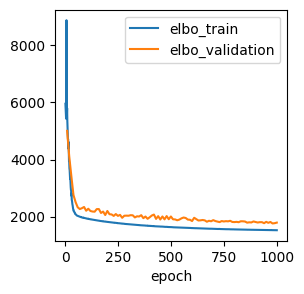

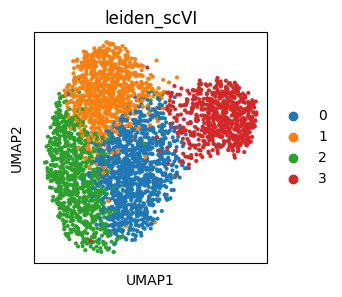

In [30]:
# baseline linear scivi vae
from scvi.model import LinearSCVI

NUMGENS = adata.n_vars
#NUMGENS = 50
dimZ = 50
dimG = 128  # dim latent
BATCHSIZE = adata.n_obs
#BATCHSIZE = 500
LEARN_RATE = 1.0e-4
USE_CUDA = True
NUM_EPOCHS = 1000
#nclusters = 10

LinearSCVI.setup_anndata(adata)
model = LinearSCVI(adata, n_hidden=dimG, n_latent=dimZ, n_layers=1, gene_likelihood='nb')
model.train(max_epochs=NUM_EPOCHS, plan_kwargs={'lr':LEARN_RATE}, check_val_every_n_epoch=10)
train_elbo = model.history['elbo_train'][1:]
test_elbo = model.history['elbo_validation']

ax = train_elbo.plot()
test_elbo.plot(ax = ax)

Z_hat = model.get_latent_representation()
# for i, z in enumerate(Z_hat.T):
#     adata.obs[f'Z_{i}'] = z

adata_z = anndata.AnnData(Z_hat)
    
adata.obsm["X_scVI"] = Z_hat

# write results
filename2 = 'human_cortex_analysis/adata_linearSCVI.h5ad'
adata_z.write(filename2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


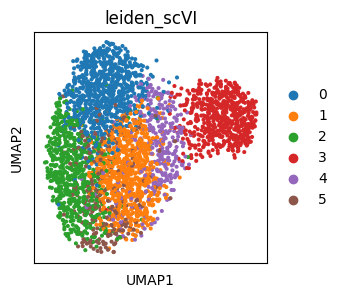

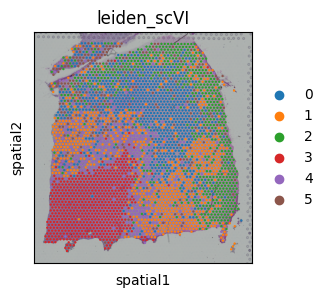

In [34]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)
sc.pl.umap(adata, color=["leiden_scVI"])

sc.pl.spatial(adata, img_key="hires", color=["leiden_scVI"])

# write results
filename2 = 'human_cortex_analysis/adata_SCVI.h5ad'
adata_z.write(filename2)

/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:Multiprocessing is handled by SLURM.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s, loss=1.44e+03, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_SCVI', the cluster labels (adata.obs, categorical) (0:00:00)


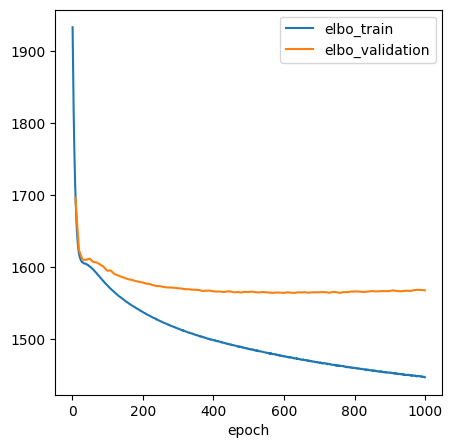

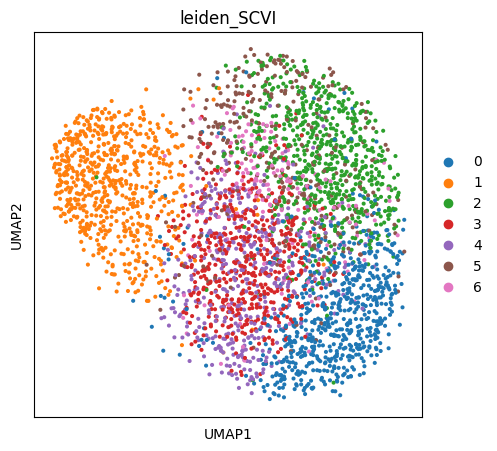

In [46]:
from scvi.model import SCVI

NUMGENS = adata.n_vars
#NUMGENS = 50
dimZ = 50
dimG = 128  # dim latent
BATCHSIZE = adata.n_obs
#BATCHSIZE = 500
LEARN_RATE = 1.0e-4
USE_CUDA = True
NUM_EPOCHS = 1000
#nclusters = 10

SCVI.setup_anndata(adata)
model = SCVI(adata, n_hidden=dimG, n_latent=dimZ, n_layers=1, gene_likelihood='nb')
model.train(max_epochs=NUM_EPOCHS, plan_kwargs={'lr':LEARN_RATE}, check_val_every_n_epoch=10)
train_elbo = model.history['elbo_train'][1:]
test_elbo = model.history['elbo_validation']

ax = train_elbo.plot()
test_elbo.plot(ax = ax)

Z_hat = model.get_latent_representation()
# for i, z in enumerate(Z_hat.T):
#     adata.obs[f'Z_{i}'] = z
    
    
adata.obsm["X_SCVI"] = Z_hat
sc.pp.neighbors(adata, use_rep="X_SCVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_SCVI", resolution=1)
sc.pl.umap(adata, color=["leiden_SCVI"])

In [52]:
adata

AnnData object with n_obs × n_vars = 3459 × 4867
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Ground Truth', 'leiden', 'mclust', '_scvi_batch', '_scvi_labels', 'leiden_SCVI'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Ground Truth_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'spatial', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'leiden_SCVI_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'X_SCVI'
    varm: 'PCs'
    obsp: 'aff_matrix', 'agg_matrix', 'connectivities', 'distances', 'gau_spa_distances', 'gene_distances', 'spa_distances'

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_SCVI', the cluster labels (adata.obs, categorical) (0:00:00)


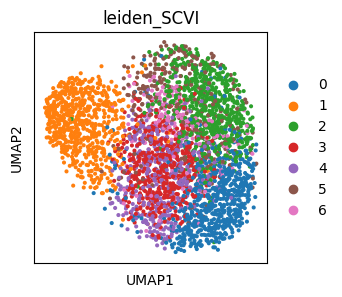

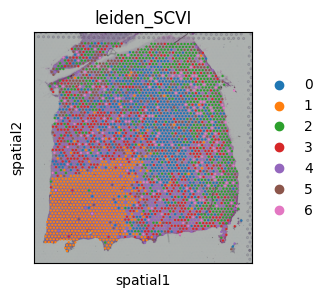

AnnData object with n_obs × n_vars = 3459 × 4867
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Ground Truth', 'leiden', 'mclust', '_scvi_batch', '_scvi_labels', 'leiden_SCVI'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Ground Truth_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'spatial', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'leiden_SCVI_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'X_SCVI'
    varm: 'PCs'
    obsp: 'aff_matrix', 'agg_matrix', 'connectivities', 'distances', 'gau_spa_distances', 'gene_distances', 'spa_distances'
Adjusted rand index = 0.18


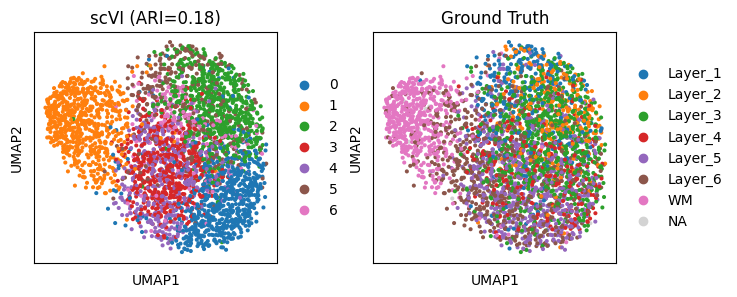

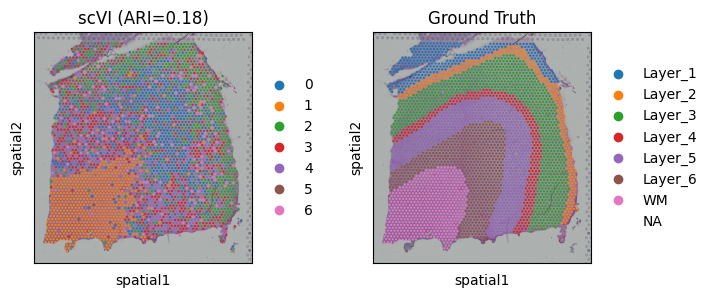

In [58]:

sc.pp.neighbors(adata, use_rep="X_SCVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_SCVI", resolution=1.0)
sc.pl.umap(adata, color=["leiden_SCVI"])

sc.pl.spatial(adata, img_key="hires", color=["leiden_SCVI"])

adata_z = anndata.AnnData(Z_hat)
# write results
filename2 = 'human_cortex_analysis/adata_SCVI.h5ad'
adata_z.write(filename2)

print(adata)
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['leiden_SCVI'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["leiden_SCVI", "Ground Truth"], title=['scVI (ARI=%.2f)'%ARI, "Ground Truth"])
sc.pl.spatial(adata, color=["leiden_SCVI", "Ground Truth"], title=['scVI (ARI=%.2f)'%ARI, "Ground Truth"])

------Calculating spatial graph...
The graph contains 20040 edges, 3459 cells.
5.7936 neighbors per cell on average.
Size of Input:  (3459, 4867)


100%|██████████| 500/500 [00:32<00:00, 15.51it/s]


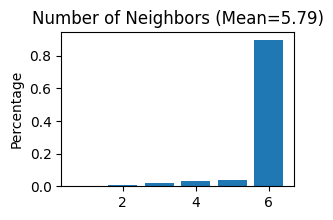

In [55]:
# STAGATE
import STAGATE
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata)

adata_STAGATE = STAGATE.train_STAGATE(adata, alpha=0)

filename = 'human_cortex_analysis/adata_STAGATE.h5ad'
adata_STAGATE.write(filename)
adata_STAGATE = anndata.read_h5ad(filename)

# sc.pp.neighbors(adata, use_rep='STAGATE')
# sc.tl.umap(adata)
# adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=7)

# obs_df = adata.obs.dropna()
# ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
# print('Adjusted rand index = %.2f' %ARI)

# plt.rcParams["figure.figsize"] = (3, 3)
# sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

# plt.rcParams["figure.figsize"] = (3, 3)
# sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])


In [64]:
adata_STAGATE.n_obs

3459

In [ ]:
# STLEARN
import stlearn as st
#from pathlib import Path
#st.settings.set_figure_params(dpi=180)

data_SME = adata.copy()
# apply stSME to normalise log transformed data
st.spatial.SME.SME_normalize(data_SME, use_data="raw")
data_SME.X = data_SME.obsm['raw_SME_normalized']
st.pp.scale(data_SME)
st.em.run_pca(data_SME,n_comps=50)

In [39]:
import gc
import numpy as np
import pandas as pd
import math
import scanpy.plotting
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.functional as F
import anndata
import pyro
import pyro.distributions as dist
from scipy.sparse import csc_matrix
from scvi.module.base import PyroBaseModuleClass
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from umap import UMAP
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam,AdagradRMSProp
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score
import os

#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

class GraphConvolution(Module):  
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        # self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        # if bias:
        #     self.bias = Parameter(torch.FloatTensor(out_features))  # bias?
        # else:
        #     self.register_parameter('bias', None)
        # self.reset_parameters()

    # def reset_parameters(self):
    #     stdv = 1. / math.sqrt(self.weight.size(1))
    #     self.weight.data.uniform_(-stdv, stdv)
    #     if self.bias is not None:
    #         self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input_layer, adj):
        # support = torch.mm(input_layer, self.weight)
        # output = torch.spmm(adj, support)
        output = torch.spmm(adj, input_layer)
        return output
        

    # def __repr__(self):
    #     return self.__class__.__name__ + ' (' \
    #            + str(self.in_features) + ' -> ' \
    #            + str(self.out_features) + ')'

class Encoder(nn.Module):
    def __init__(self, in_dim, z_dim, hidden_dim, dropout):
        super().__init__()
        #self.gc1 = GraphConvolution(in_dim, nhid)
        self.gc1 = GraphConvolution(in_dim, in_dim)
        #self.gc1 = nn.Linear(in_dim, nhid)
        self.dropout = dropout
        #self.fc1 = nn.Sequential(nn.Linear(nhid, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.Softplus())
        #self.fc1 = nn.Linear(nhid, hidden_dim)
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        #self.fc3 = nn.Linear(256, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()

    def forward(self, x, adj):
        ###
        x = self.gc1(x, adj)  # ReLU(AXW)
        #x = F.relu(self.gc1(x, adj))  # ReLU(AXW)
        #x = F.dropout(x, self.dropout, training=self.training)
        hidden = self.softplus(self.fc1(x))
        #hidden1 = self.softplus(self.fc3(hidden))
        z_loc = self.fc21(hidden)  # shouldn't use activation function here normal dist mean can be <0
        z_scale = torch.exp(self.softplus(self.fc22(hidden)))  # keep for std
        # latent z
        return z_loc, z_scale

    
class Decoder(nn.Module):
    def __init__(self, in_dim, z_dim, hidden_dim):
        super().__init__()

        #self.fc1 = nn.Sequential(nn.Linear(z_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.Softplus())
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        #self.fc3 = nn.Linear(hidden_dim, 256)
        #self.fc21 = nn.Linear(hidden_dim, in_dim)
        #self.fc22 = nn.Linear(hidden_dim, in_dim)
        self.fc21 = nn.Linear(hidden_dim, in_dim)
        self.fc22 = nn.Linear(hidden_dim, in_dim)

        self.softplus = nn.Softplus()

    def forward(self, z):
        ###
        #hidden = self.softplus(self.fc1(z))
        hidden = self.softplus(self.fc1(z))
        #hidden1 = self.softplus(self.fc3(hidden))
        count = self.softplus(self.fc21(hidden))
        prob = self.softplus(self.fc22(hidden))
        
        ######
        return count, prob



class VAE(PyroBaseModuleClass):
    def __init__(self, n_input, n_latent, hidden_dim, dropout):
        super().__init__()
        self.n_latent = n_latent
        self.n_input = n_input
        self.encoder = Encoder(n_input, n_latent, hidden_dim,  dropout)
        self.decoder = Decoder(n_input, n_latent, hidden_dim)
        
        self.log_theta = torch.nn.Parameter(torch.randn(n_input))  # both free params, only one should be free
        self.gate_logits = torch.nn.Parameter(torch.randn(n_input),requires_grad=True) # free param, decode from z ask yumin
        

    def model(self, x,adj):
        pyro.module("decoder", self)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.n_latent)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.n_latent)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))  # loss
            
            
            count, prob = self.decoder(z)
            ######
            x_dist = dist.ZeroInflatedNegativeBinomial(total_count=count+1,probs=prob, gate_logits=self.gate_logits)
            rx=pyro.sample("obs1", x_dist.to_event(1), obs=x)  # loss function calculated added tgt
            return rx
        
        
#              # get the "normalized" mean of the negative binomial
#             px_scale, px_dropout = self.decoder(z)
            
#             # get the mean of the negative binomial
#             #px_scale
#             # log_library = library_size  
#             px_rate =px_scale # torch.exp(library_size) * px_scale
#             # get the dispersion parameter
#             theta = torch.exp(self.log_theta)
#             glog=self.gate_logits
#             # build count distribution
#             nb_logits = (px_rate + 1e-4).log() - (theta + 1e-4).log()
#             # nb_logits = (px_rate + 5.0e-2).log() - (theta + 5.0e-2).log()

#             # x_dist = dist.ZeroInflatedNegativeBinomial(total_count=theta, logits=nb_logits, gate_logits=glog)
#             x_dist = dist.ZeroInflatedNegativeBinomial(total_count=theta, logits=nb_logits, gate_logits=px_dropout)
#             # score against actual counts
#             rx=pyro.sample("obs1", x_dist.to_event(1), obs=x)
#             return rx
        
        
    def guide(self, x,adj):
        pyro.module("encoder", self)
        with pyro.plate("data", x.shape[0]):
            x_ = torch.log(1+x)
            [qz_m, qz_v] = self.encoder(x_,adj)
            pyro.sample("latent", dist.Normal(qz_m,qz_v).to_event(1))  # loss nearest to std norm dist in vae(can be other dist)


    def getZ(self, x, adj):  # 
        z_loc, z_scale = self.encoder(x,adj)
        #z = dist.Normal(z_loc, z_scale).sample()  # try
        #z = z_loc + z_scale
        z = z_loc
        return z




def train(svi, train_loader, adj, use_cuda=True):
    epoch_loss = 0
    for x in train_loader:
        #print(x)
        if use_cuda:
            x = x.cuda()
            adj = adj.cuda()
        epoch_loss += svi.step(x,adj)

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train



INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [40]:
torch.cuda.is_available()
gc.collect()
torch.cuda.empty_cache()

[epoch 000] average training loss: 6138.1899
[epoch 001] average training loss: 6055.0248
[epoch 002] average training loss: 5961.4269
[epoch 003] average training loss: 5884.9354
[epoch 004] average training loss: 5790.8084
[epoch 005] average training loss: 5717.2763
[epoch 006] average training loss: 5631.5265
[epoch 007] average training loss: 5543.0909
[epoch 008] average training loss: 5470.2043
[epoch 009] average training loss: 5389.3747
[epoch 010] average training loss: 5323.6804
[epoch 011] average training loss: 5243.3904
[epoch 012] average training loss: 5167.5680
[epoch 013] average training loss: 5102.5239
[epoch 014] average training loss: 5034.2289
[epoch 015] average training loss: 4972.8828
[epoch 016] average training loss: 4892.9568
[epoch 017] average training loss: 4824.0137
[epoch 018] average training loss: 4766.5109
[epoch 019] average training loss: 4699.0525
[epoch 020] average training loss: 4634.2211
[epoch 021] average training loss: 4574.7800
[epoch 022

/tmp/ipykernel_197082/56221086.py:87: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_z = anndata.AnnData(TZ)
/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


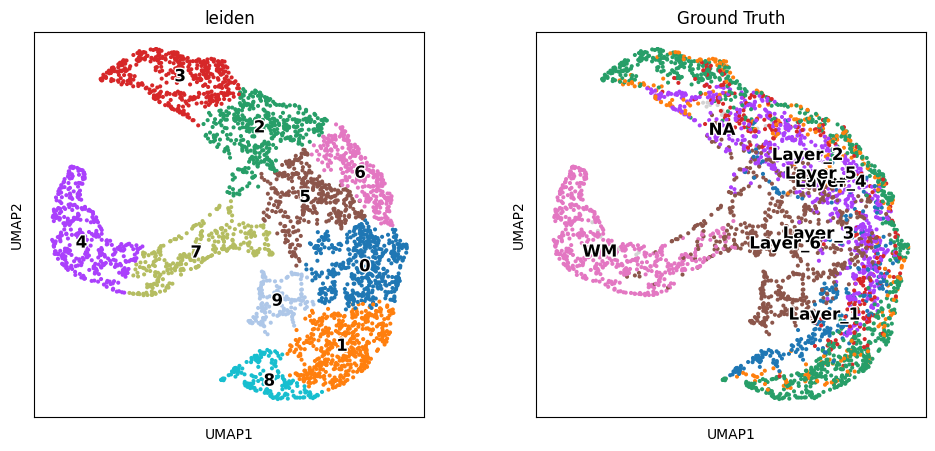

ARI: 0.22074263586992562  NMI: 0.3738803936557955


In [41]:
torch.cuda.empty_cache()

class H5ADataSet(Dataset):
    def __init__(self, adata):
        self.data = adata

    def __len__(self):
        return self.data.X.shape[0]

    def __getitem__(self, idx):
        x = csc_matrix(self.data.X[idx])[0].toarray()[0]
        x_tensor = x.astype(np.float32)
        return x_tensor

    
def load_data(adata):
    adj = adata.obsp["agg_matrix"]/100  # 154x154 for pcw4
    features = adata.obs.copy() #154x50
    return adj, features

dataset = adata
adj, features = load_data(dataset)

celldata = H5ADataSet(dataset)
print(celldata)

NUMGENS = adata.n_vars
#NUMGENS = 50
dimZ = 50
dimG = 128  # dim latent
BATCHSIZE = adata.n_obs
#BATCHSIZE = 256
LEARN_RATE = 1.0e-4
USE_CUDA = True
NUM_EPOCHS = 500
TEST_FREQUENCY=5
start=0
end=adata.n_vars-1
cell_loader = DataLoader(celldata, batch_size=BATCHSIZE)
#cell_loader = DataLoader(features, batch_size=BATCHSIZE)

pyro.clear_param_store()

# (self, n_input, n_latent, hidden_dim, n_clusters, dropout):
vae = VAE(NUMGENS, dimZ, dimG, 0.5)
#vae = myGrphVAEPyroModule(NUMGENS, dimZ, dimG, 0.5)
#vae = NBlinearVAEPyroModule(NUMGENS, dimZ, dimG, 0.5)
if USE_CUDA:
    vae.cuda()
    
adam_args ={"lr":LEARN_RATE}
optimizer = ClippedAdam(adam_args)

elbo = Trace_ELBO(strict_enumeration_warning=False)
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

gc.collect()
torch.cuda.empty_cache()

train_elbo = []
test_elbo = []

adj = torch.FloatTensor(adj)


for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, cell_loader, adj, use_cuda=USE_CUDA)
    #total_epoch_loss_train = train(svi, cell_loader, adj, start, end, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))
    #if epoch % TEST_FREQUENCY == 0:
        

torch.save(vae,'./vae.pkl')

TZ = []
for x in cell_loader:
    if USE_CUDA:
        x = x.cuda()
        adj = adj.cuda()
    z = vae.getZ(x,adj)
    #z = vae.getZ(x,adj,start,end)
    zz = z.cpu().detach().numpy().tolist()
    TZ+=zz
TZ = np.array(TZ)
TZ = pd.DataFrame(TZ)
adata_z = anndata.AnnData(TZ)
print(adata_z)
#scanpy.pp.neighbors(adata_z)
sc.pp.neighbors(adata_z, n_neighbors=10, n_pcs=50)
scanpy.tl.leiden(adata_z,resolution=0.2)
sc.tl.paga(adata_z)
sc.pl.paga(adata_z, plot=False)
#scanpy.tl.umap(adata_z)
sc.tl.umap(adata_z, init_pos='paga')

plt.rcParams["figure.figsize"] = (5,5)

adata_z.obs['Ground Truth'] = np.asarray(adata.obs['Ground Truth'])
scanpy.pl.umap(adata_z,color=['leiden','Ground Truth'], palette=scanpy.pl.palettes.default_20,  legend_loc = 'on data',legend_fontsize = 12,legend_fontoutline=2)

obs_df = adata_z.obs.dropna()
ARI = adjusted_rand_score(obs_df['leiden'], obs_df['Ground Truth'])
#ARI = adjusted_rand_score(adata_z.obs['Ground Truth'], adata_z.obs['leiden'])
NMI = normalized_mutual_info_score(obs_df['Ground Truth'],obs_df['leiden'])
print("ARI: "+str(ARI)+"  "+"NMI: "+str(NMI))

AnnData object with n_obs × n_vars = 3459 × 50
computing neighbors
    using data matrix X directly


/tmp/ipykernel_197082/1821688473.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_z = anndata.AnnData(TZ)
/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


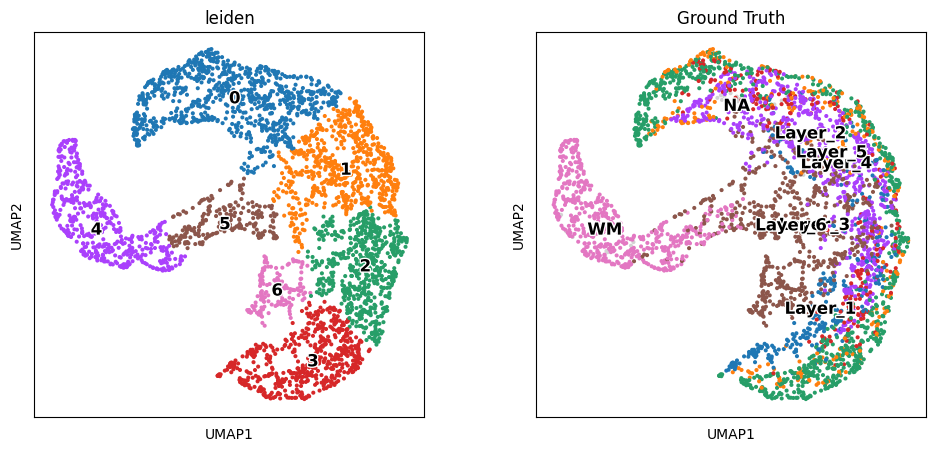

ARI: 0.21986042641318554  NMI: 0.3597890002865551


In [43]:
TZ = []
for x in cell_loader:
    if USE_CUDA:
        x = x.cuda()
        adj = adj.cuda()
    z = vae.getZ(x,adj)
    #z = vae.getZ(x,adj,start,end)
    zz = z.cpu().detach().numpy().tolist()
    TZ+=zz
TZ = np.array(TZ)
TZ = pd.DataFrame(TZ)
adata_z = anndata.AnnData(TZ)
print(adata_z)
#scanpy.pp.neighbors(adata_z)
sc.pp.neighbors(adata_z, n_neighbors=10, n_pcs=50)
scanpy.tl.leiden(adata_z,resolution=0.1)
sc.tl.paga(adata_z)
sc.pl.paga(adata_z, plot=False)
#scanpy.tl.umap(adata_z)
sc.tl.umap(adata_z, init_pos='paga')

plt.rcParams["figure.figsize"] = (5,5)

adata_z.obs['Ground Truth'] = np.asarray(adata.obs['Ground Truth'])
scanpy.pl.umap(adata_z,color=['leiden','Ground Truth'], palette=scanpy.pl.palettes.default_20,  legend_loc = 'on data',legend_fontsize = 12,legend_fontoutline=2)

obs_df = adata_z.obs.dropna()
ARI = adjusted_rand_score(obs_df['leiden'], obs_df['Ground Truth'])
#ARI = adjusted_rand_score(adata_z.obs['Ground Truth'], adata_z.obs['leiden'])
NMI = normalized_mutual_info_score(obs_df['Ground Truth'],obs_df['leiden'])
print("ARI: "+str(ARI)+"  "+"NMI: "+str(NMI))

In [44]:
filename = 'human_cortex_analysis/adata_GVAE_05.h5ad'
adata.write(filename)
adata = anndata.read_h5ad(filename)

filename2 = 'human_cortex_analysis/adata_z_GVAE_train05.h5ad'
adata_z.write(filename2)
adata_z = anndata.read_h5ad(filename2)

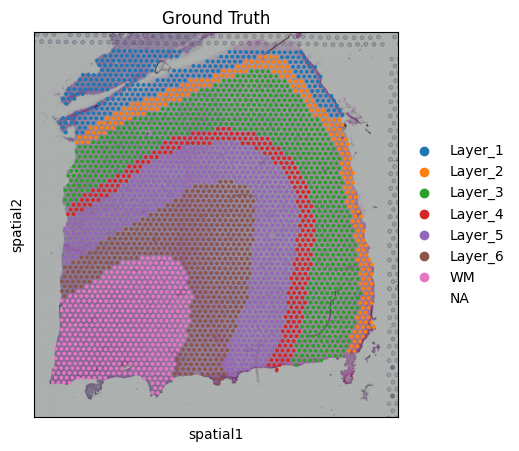

In [46]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

In [27]:
adata

AnnData object with n_obs × n_vars = 3460 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'leiden', 'scanpy'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'Ground Truth_colors', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'leiden_colors', 'pca', 'scanpy_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spa_distances', 'gau_spa_distances', 'gene_distances', 'aff_matrix', 'agg_matrix'

In [ ]:
#plt.rcParams["figure.figsize"] = (5,5)
#print(grouped_pcw4[1, 'ENSG00000000003.14'].X[0][0])
print(adata.obs['leiden'])
adata.obs['scanpy'] = adata_z.obs['scanpy']
adata.uns['scanpy_colors'] = adata_z.uns['scanpy_colors']
adata_z.obsm['spatial'] = adata.obsm['spatial']
adata_z.uns['spatial'] = adata.uns['spatial']
sc.pl.spatial(adata_z, img_key="hires", color=["Ground Truth"])
sc.pl.spatial(adata, img_key="hires", color=["leiden"])
sc.pl.spatial(adata_z, img_key="hires", color=["leiden"], save="model_clusters.png")


reading gvae_model/data/151676_filtered_feature_bc_matrix.h5
 (0:00:00)


/lustre03/project/6064798/xding14/jupyter_py3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell
    finished (0:00:00)


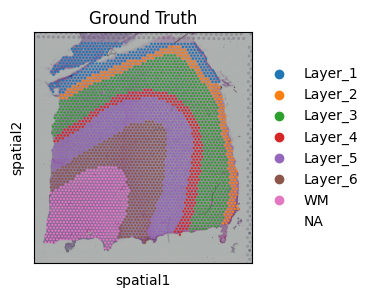

computing PCA
    with n_comps=50
    finished (0:00:14)


In [22]:
section_id = '151676'

input_dir = './gvae_model/data'
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

#Normalization
#sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) # try without

# read the annotation
Ann_df = pd.read_csv(os.path.join(input_dir, 'spatial', section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])

sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


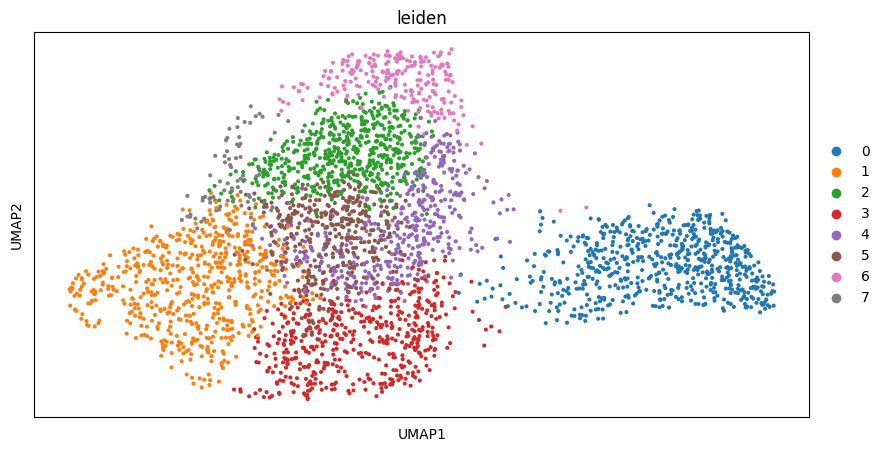

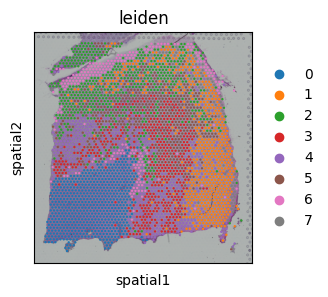

In [23]:

plt.rcParams["figure.figsize"] = (10,5)
# neighborhood graph
#sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.leiden(adata)
# embedding using UMAP
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
# cluster
sc.pl.umap(adata, color=['leiden'])
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["leiden"])

In [27]:
cchat_adata = adata
cchat_adata.obs['leiden'] = ["cluster_"+i for i in cchat_adata.obs['leiden']]

In [29]:
#
cchat_adata.write('cchat_adata.h5ad')

In [28]:
cchat_adata.obs['leiden'] 

AAACAAGTATCTCCCA-1    cluster_5
AAACAATCTACTAGCA-1    cluster_5
AAACACCAATAACTGC-1    cluster_0
AAACAGAGCGACTCCT-1    cluster_5
AAACAGGGTCTATATT-1    cluster_4
                        ...    
TTGTTGTGTGTCAAGA-1    cluster_5
TTGTTTCACATCCAGG-1    cluster_0
TTGTTTCATTAGTCTA-1    cluster_0
TTGTTTCCATACAACT-1    cluster_6
TTGTTTGTGTAAATTC-1    cluster_2
Name: leiden, Length: 3460, dtype: object

In [ ]:
# STAGATE: TESTING RANDOM SEEDS FOR CELL CELL INTERACTION
ARI_scores = np.empty(100)
for i in range(1, 101):
    print(i)
    #adata = anndata.read_h5ad('human_cortex_analysis/adata_STAGATE.h5ad')
    adata_z = anndata.read_h5ad(f'human_cortex_analysis/test_STAGATE/test_{i}.h5ad')

    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('int')
    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('str')
    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('category')

    sc.pp.neighbors(adata_z, use_rep='STAGATE')
    sc.tl.paga(adata_z)
    sc.pl.paga(adata_z, plot=False)
    #sc.pp.neighbors(adata, use_rep='STAGATE')
    sc.tl.umap(adata_z)

    obs_df = adata_z.obs.drop('scanpy', axis=1).dropna()
    ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
    ARI_scores[i-1] = ARI
    

In [11]:
#STAGATE_ARI = ARI_scores
print(STAGATE_ARI.argmax())
print(STAGATE_ARI[38])
print(np.mean(STAGATE_ARI))

38
0.4203970382531454
0.3190078124877555


AnnData object with n_obs × n_vars = 3459 × 4867
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Ground Truth', 'leiden', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_SCVI', 'scanpy', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Ground Truth_colors', 'Spatial_Net', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_SCVI_colors', 'leiden_colors', 'leiden_scVI_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'scanpy_colors', 'spatial', 'umap'
    obsm: 'STAGATE', 'X_SCVI', 'X_pca', 'X_scVI', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'aff_matrix', 'agg_matrix', 'connectivities', 'distances', 'gau_spa_distances', 'gene_distances', 'spa_distances'
computing neighbors
    finished: added to `.uns[

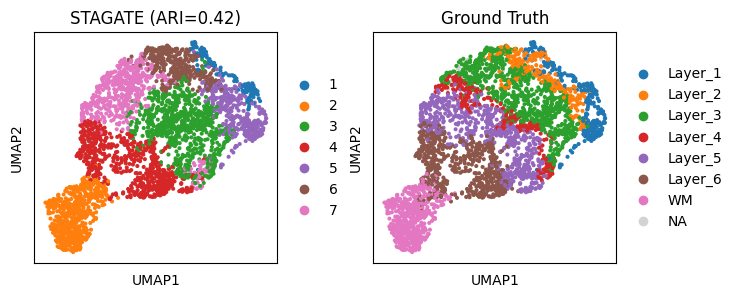

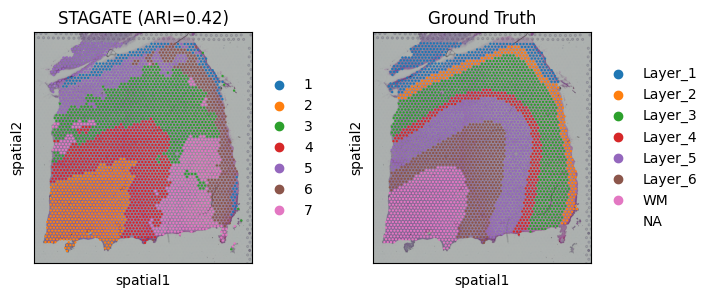

In [13]:
# STAGATE results
i = STAGATE_ARI.argmax()+1  # bc R indexing >:((
adata = anndata.read_h5ad('human_cortex_analysis/adata_STAGATE.h5ad')
adata_z = anndata.read_h5ad(f'human_cortex_analysis/test_STAGATE/test_{i}.h5ad')
print(adata_z)

adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('int')
adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('str')
adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('category')

sc.pp.neighbors(adata_z, use_rep='STAGATE')
sc.tl.paga(adata_z)
sc.pl.paga(adata_z, plot=False)
#scanpy.tl.umap(adata_z)
sc.tl.umap(adata_z, init_pos='paga')
scanpy.tl.leiden(adata_z,resolution=0.2)

obs_df = adata_z.obs.drop('scanpy', axis=1).dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata_z, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata_z, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"])

In [ ]:
# GVAE: TESTING RANDOM SEEDS FOR CELL CELL INTERACTION
GVAE_ARI = np.empty(100)
for i in range(1, 101):
    print(i)
    adata = anndata.read_h5ad('human_cortex_analysis/adata_GVAE_05.h5ad')
    adata_z = anndata.read_h5ad(f'human_cortex_analysis/test_GVAE/test_{i}.h5ad')

    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('int')
    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('str')
    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('category')
    adata.obs['mclust'] = np.asarray(adata_z.obs['mclust'])
    adata.obsm['GVAE'] = adata_z.X

    sc.pp.neighbors(adata, use_rep='GVAE')
    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=False)
    #sc.pp.neighbors(adata, use_rep='STAGATE')
    sc.tl.umap(adata)

    obs_df = adata_z.dropna()
    ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
    GVAE_ARI[i-1] = ARI

In [18]:
#STAGATE_ARI = ARI_scores
print(GVAE_ARI.argmax())
print(GVAE_ARI[GVAE_ARI.argmax()])
print(np.mean(GVAE_ARI))

66
0.26901034509035804
0.21697486111092532


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
Adjusted rand index = 0.27


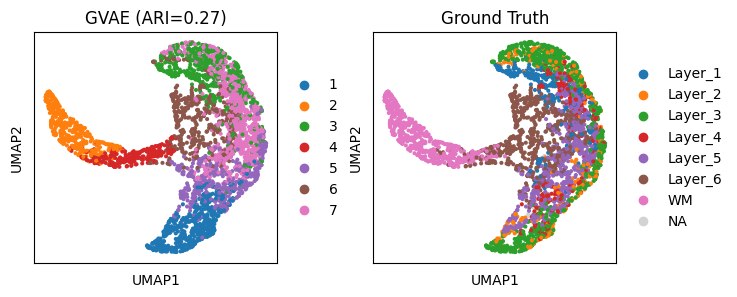

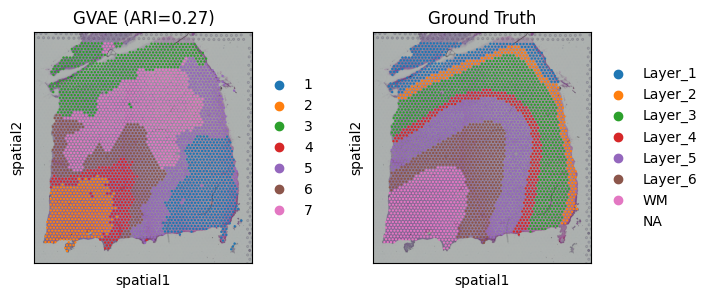

In [20]:
# GVAE CELL CELL INTERACTION
i = GVAE_ARI.argmax()+1  # bc R indexing >:((

adata = anndata.read_h5ad('human_cortex_analysis/adata_GVAE_05.h5ad')
adata_z = anndata.read_h5ad(f'human_cortex_analysis/test_GVAE/test_{i}.h5ad')
#adata_z = anndata.read_h5ad(f'test_gvae/test_35.h5ad')
#adata = anndata.read_h5ad('adata_STAGATE.h5ad')
#adata_z = anndata.read_h5ad('adata_STAGATE_mclust.h5ad')

adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('int')
adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('str')
adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('category')
adata.obs['mclust'] = np.asarray(adata_z.obs['mclust'])
adata.obsm['GVAE'] = adata_z.X

sc.pp.neighbors(adata, use_rep='GVAE')
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
#sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

obs_df = adata_z.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['GVAE (ARI=%.2f)'%ARI, "Ground Truth"])

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['GVAE (ARI=%.2f)'%ARI, "Ground Truth"])

In [ ]:
# scvi: TESTING RANDOM SEEDS FOR CELL CELL INTERACTION
SCVI_ARI = np.empty(100)
for i in range(1, 41):
    print(i)
    #adata = anndata.read_h5ad('human_cortex_analysis/adata_GVAE_05.h5ad')
    adata_z = anndata.read_h5ad(f'human_cortex_analysis/test_SCVI/test_{i}.h5ad')
    print(adata_z)

    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('int')
    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('str')
    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('category')
    adata.obs['mclust'] = np.asarray(adata_z.obs['mclust'])
    #adata.obsm['SCVI'] = adata_z.X

    sc.pp.neighbors(adata, use_rep='X_SCVI')
    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=False)
    #sc.pp.neighbors(adata, use_rep='STAGATE')
    sc.tl.umap(adata)

    obs_df = adata.obs.drop('scanpy', axis=1).dropna()
    ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
    SCVI_ARI[i-1] = ARI

In [30]:
adata_scvi = anndata.read_h5ad('human_cortex_analysis/adata_SCVI_mclust.h5ad')
#adata = anndata.read_h5ad('human_cortex_analysis/adata_GVAE_05.h5ad')
print(adata_scvi)
#print(adata)

AnnData object with n_obs × n_vars = 3459 × 4867
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Ground Truth', 'leiden', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'leiden_SCVI', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Ground Truth_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_SCVI_colors', 'leiden_colors', 'leiden_scVI_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'spatial', 'umap'
    obsm: 'X_SCVI', 'X_pca', 'X_scVI', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'aff_matrix', 'agg_matrix', 'connectivities', 'distances', 'gau_spa_distances', 'gene_distances', 'spa_distances'


In [ ]:
# SCVI CELL CELL INTERACTION
#i = SCVI_ARI.argmax()+1  # bc R indexing >:((

#adata = anndata.read_h5ad('human_cortex_analysis/adata_GVAE_05.h5ad')
#adata_z = anndata.read_h5ad(f'human_cortex_analysis/test_SCVI/test_{i}.h5ad')
adata_z = anndata.read_h5ad('human_cortex_analysis/adata_SCVI_mclust.h5ad')

adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('int')
adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('str')
adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('category')
adata.obs['mclust'] = np.asarray(adata_z.obs['mclust'])

sc.pp.neighbors(adata, use_rep='X_SCVI')
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
#sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
scanpy.tl.leiden(adata,resolution=0.9)

obs_df = adata_z.obs.dropna()
ARI = adjusted_rand_score(obs_df['leiden'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["leiden", "Ground Truth"], title=['SCVI (ARI=%.2f)'%ARI, "Ground Truth"])

plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["leiden", "Ground Truth"], title=['SCVI (ARI=%.2f)'%ARI, "Ground Truth"])

In [ ]:
#sc.settings.verbosity = 2  # reduce the verbosity
#sc.pp.normalize_total(adata)
# find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added='rank_genes_groups_scanpy')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

sc.tl.rank_genes_groups(adata, 'mclust', method='wilcoxon', key_added='rank_genes_groups_gvae')

# get top 100 ranked genes per cluster
top_markers_scanpy = pd.DataFrame(adata.uns['rank_genes_groups_scanpy']['names']).head(100)
top_markers_gvae = pd.DataFrame(adata.uns['rank_genes_groups_gvae']['names']).head(100)

# convert gene names
def fix(name):
    return name.split(".")[0]
#fixed_markers_scanpy = top_markers_scanpy#.apply(np.vectorize(fix))
#fixed_markers_vae = top_markers_gvae#.apply(np.vectorize(fix))

# scanpy markers
# for column in top_markers_scanpy:
#     out = mg.querymany(fixed_markers_scanpy[column], scopes="ensemblgene", fields="symbol", species='human', as_dataframe=True)
#     out["ensemblgene"] = out.index.to_series()
#     #out["symbol"].fillna(out["ensemblgene"], inplace=True)
#     print(out.head(5))
#     top_markers_scanpy[column+"_symbol"] = out["symbol"].values
#     #top_markers_scanpy4[column+"_spatial score"] = grouped_pcw4.var["spatial_score"].loc[top_markers_scanpy4[column]].values
    
# # vae markers
# for column in top_markers_gvae:
#     out = mg.querymany(fixed_markers_gvae[column], scopes="ensemblgene", fields="symbol", species='human', as_dataframe=True)
#     out["ensemblgene"] = out.index.to_series()
#     #out["symbol"].fillna(out["ensemblgene"], inplace=True)
#     print(out.head(5))
#     top_markers_gvae[column+"_symbol"] = out["symbol"].values
#     #top_markers_vae4[column+"_spatial score"] = grouped_pcw4.var["spatial_score"].loc[top_markers_vae4[column]].values

    
# output
#print(top_markers_scanpy)
#print(top_markers_gvae)
top_markers_scanpy.to_csv("scanpy_markers.csv")
top_markers_gvae.to_csv("gvae_markers.csv")

ranking genes
    finished: added to `.uns['rank_genes_groups_scanpy']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)
ranking genes
    finished: added to `.uns['rank_genes_groups_gvae']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


In [ ]:
# TESTING RANDOM SEEDS FOR CELL CELL INTERACTION
STAGATE_ARI_scores = np.empty(100)
for i in range(1, 101):
    print(i)
    adata = anndata.read_h5ad('adata_GVAE_train05.h5ad')
    adata_z = anndata.read_h5ad(f'test_gvae/test_{i}.h5ad')
    
    #adata = anndata.read_h5ad('adata_STAGATE.h5ad')
    #adata_z = anndata.read_h5ad(f'test_stagate/test_{i}.h5ad')

    #adata = anndata.read_h5ad('adata_STAGATE.h5ad')
    #adata_z = anndata.read_h5ad('adata_STAGATE_mclust.h5ad')

    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('int')
    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('str')
    adata_z.obs['mclust'] = adata_z.obs['mclust'].astype('category')

    adata.obs['mclust'] = np.asarray(adata_z.obs['mclust'])
    adata.obsm['GVAE'] = adata_z.X

    sc.pp.neighbors(adata, use_rep='GVAE')
    #sc.pp.neighbors(adata, use_rep='STAGATE')
    sc.tl.umap(adata)

    obs_df = adata_z.obs.dropna()
    ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
    ARI_scores[i-1] = ARI
    

In [9]:
STAGATE_ARI = ARI_scores

In [8]:
print(ARI_scores.argmax())
print(ARI_scores[38])
print(np.mean(ARI_scores))

38
0.4203970382531454
0.3190078124877555


In [69]:
# import seaborn as sns
# #sns.set_style('whitegrid')
# ax= sns.boxplot(x='Survived',y='Age',data=df)
# ax = sns.stripplot(x="Survived", y="Age",data=df)

In [ ]:
import gc
gc.collect()